In [13]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI

In [14]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/"
#data_dir = "P:/John/analyzed_archived/scnn1a-tg3-cre/PPR checkpoints/scnn1a-ppr/"
master_csv = data_dir + 'scnn1a-ppr.csv'
###################################
# Process paired-pulse ratio data
#    - IPIs are shuffled, open <slice>_<loc>shuffle.txt for IPI order
#    - extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
#    - ROIs are in order (in file "<slice>_barrel_rois.dat" for each date subdir):
#          -  medial -> lateral if available
#          - otherwise, in some order that preserves neighbors (1,2 are neighbors and 2,3 are neighbors)
#    - which barrel is home barrel (stimulated) is recorded in master csv scnn1a-ppr.csv for each loc
###################################
enable_photoZ_interact = False
initialize_photoZ = True
disable_trace_export = True  # if True, don't export traces, only save arrays

snr_cutoff_signal = 0
amp_cutoff = 2

In [15]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()
    # normalization needs to be off since we are saving arrays
    aPhz.click_normalize_2_array_max()

In [16]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel
0,12/8/2023,3_2,up,L2/3,Caudal,2
1,12/8/2023,4_1,NaN,L4,Rostral,2
2,12/8/2023,5_1,NaN,L4,Rostral,1
3,12/8/2023,5_2,NaN,L4,Rostral,2
4,12/8/2023,6_1,NaN,L4,NaN,1
5,12/8/2023,6_2,NaN,L4,NaN,2
6,12/13/2023,1_4,NaN,L2/3,Rostral,1
7,12/13/2023,2_1,NaN,L4,Rostral,1
8,12/13/2023,3_1,NaN,L4,Caudal,2
9,12/13/2023,3_2,NaN,L2/3,Caudal,2


In [17]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('dic' in dirs and 'selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it
                data_map[subdir][slic_id] = {'roi_file': subdir + "/" + get_barrel_roi_filename(slic_id)}
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': [],
                                                     'shuffle_file': subdir + "/" +  get_shuffle_filename(slic_id, loc_id)}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)  # appends in ascending order


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 2 8
3 2 9
3 2 10
3 2 11
3 2 12
3 2 13
3 2 14
3 2 15
3 2 16
3 2 17
4 1 1
4 1 2
4 1 3
4 1 4
4 1 5
4 1 6
4 1 7
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 1 15
4 1 16
5 1 2
5 1 3
5 1 4
5 1 5
5 1 6
5 1 7
5 1 8
5 1 9
5 1 10
5 1 11
5 1 12
5 1 13
5 1 14
5 1 15
5 1 16
5 1 17
5 2 2
5 2 3
5 2 4
5 2 5
5 2 6
5 2 7
5 2 8
5 2 9
5 2 10
5 2 11
5 2 12
5 2 13
5 2 14
5 2 15
5 2 16
5 2 17
6 1 4
6 1 5
6 1 6
6 1 7
6 1 8
6 1 9
6 1 10
6 1 11
6 1 12
6 1 13
6 1 14
6 1 15
6 1 16
6 1 17
6 1 18
6 1 19
6 2 1
6 2 2
6 2 3
6 2 4
6 2 5
6 2 6
6 2 7
6 2 8
6 2 9
6 2 10
6 2 11
6 2 12
6 2 13
6 2 14
6 2 15
6 2 16


In [18]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
copy_enable_photoZ_interact = enable_photoZ_interact
enable_photoZ_interact = not disable_trace_export

for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:

        # open roi_file for whole slice
        if enable_photoZ_interact:
            roi_file = data_map[subdir][slic_id]['roi_file']
            aPhz.select_roi_tab()
            aPhz.open_roi_file(roi_file)

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]
            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                for i_pulse in [1, 2]:
                    if enable_photoZ_interact:
                        measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                        aPhz.set_measure_window(measure_window_start, None)

                        # change polynomial skip window too to match measure window
                        aPhz.set_polynomial_skip_window(measure_window_start)

                    # take Amplitude, half_width, latency and label which pulse
                    # save SNR values from PhotoZ
                    snr_filename = subdir + "/" + "SNR_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_SNR_trace_value()
                        aPhz.save_trace_values(snr_filename)

                    # save half-width values from PhotoZ
                    hw_filename = subdir + "/" + "hw_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_half_width_trace_value()
                        aPhz.save_trace_values(hw_filename)

                    # save amp values from PhotoZ
                    amp_filename = subdir + "/" + "amp_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_maxamp_trace_value()
                        aPhz.save_trace_values(amp_filename)
                        
                    # save latency values from PhotoZ
                    lat_filename = subdir + "/" + "lat_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_latency_trace_value()
                        aPhz.save_trace_values(lat_filename)


                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {'amp': amp_filename,
                                                                       'hw': hw_filename,
                                                                       'snr': snr_filename,
                                                                       'lat': lat_filename}
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
enable_photoZ_interact = copy_enable_photoZ_interact  

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06.z

In [19]:
# Also extract actual pulse admin times for pulse 1 and pulse 2
if enable_photoZ_interact:
    pa.alert("Make sure the only trace selected is analog input from stimulator")
latency_selected =  False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not latency_selected and enable_photoZ_interact:
        latency_selected = True
        aPhz.select_latency_trace_value()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]
            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                for i_pulse in [1, 2]:
                    if enable_photoZ_interact:
                        measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                        aPhz.set_measure_window(measure_window_start, None)

                        # change polynomial skip window too to match measure window
                        aPhz.set_polynomial_skip_window(measure_window_start)
                    
                    # save pulse admin times
                    pa_filename = subdir + "/" + "pa_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['pa'] = pa_filename

                    if enable_photoZ_interact:
                        aPhz.save_trace_values(pa_filename)
                        print("\t Saved file", pa_filename)

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06.z

In [20]:
# load all these amp, hw, snr, lat into a dataframe
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['ROI',  'Value'])
    return data_arr

snr_dfs = []
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:
                if type(ipi) == str:
                    continue
                for i_pulse in data_map[subdir][slic_id][loc_id][ipi]:
                    dm = data_map[subdir][slic_id][loc_id][ipi][i_pulse]
                    
                    try:
                        amp = read_dat_trace_file(dm['amp'])
                        hw = read_dat_trace_file(dm['hw'])
                        snr = read_dat_trace_file(dm['snr'])
                        lat = read_dat_trace_file(dm['lat'])
                        actual_stim = read_dat_trace_file(dm['pa'])  # will be 2 values per pulse per recording, broadcast to all ROIs
                    except Exception as e:
                        print(e)
                        continue
                    actual_stim = actual_stim['Value'].item()
                    snr = snr.join(amp, rsuffix='_amp')
                    snr = snr.join(hw, rsuffix='_hw')
                    snr = snr.join(lat, rsuffix='_lat')
                    snr.insert(4, 'Pulse', [i_pulse for _ in range(len(snr['ROI']))])
                    snr.insert(5, 'IPI', [ipi for _ in range(len(snr['ROI']))])
                    snr.insert(6, 'Medial Dir', [medial_dir for _ in range(len(snr['ROI']))])
                    snr.insert(7, 'Stim Layer', [stim_layer for _ in range(len(snr['ROI']))])
                    snr.insert(8, 'Caudal/Rostral', [caudal_rostral for _ in range(len(snr['ROI']))])
                    snr.insert(9, 'Home Barrel', [home_barrel for _ in range(len(snr['ROI']))])
                    snr.insert(10, 'Date', [date for _ in range(len(snr['ROI']))])
                    snr.insert(11, 'Slice_Loc', [slic_loc_id for _ in range(len(snr['ROI']))])
                    snr.insert(12, "Actual Stim", [actual_stim for _ in range(len(snr['ROI']))])
                    snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]
                    snr_dfs.append(snr)
        
pre_filter_snr = pd.concat(snr_dfs)
pre_filter_snr = pre_filter_snr[['Date', 'Slice_Loc', 'ROI', 'Value', 'Value_amp', 'Value_hw', 
                                 'Value_lat', 'Pulse', 'IPI',
                                 'Medial Dir', 'Stim Layer', 'Caudal/Rostral', 'Home Barrel', 'Actual Stim']]

# correct Latency for actual stim time
pre_filter_snr['Value_lat'] = pre_filter_snr['Value_lat'] - pre_filter_snr['Actual Stim']

pre_filter_snr = pre_filter_snr.rename(columns={'Value': "SNR",
                                                'Value_amp': "Amp", 
                                                'Value_hw' : "Halfwidth", 
                                                'Value_lat': "Latency"})
pre_filter_snr["Amp"] = pd.to_numeric(pre_filter_snr["Amp"])
pre_filter_snr['PPR'] = ''
pre_filter_snr

,Date,Slice_Loc,ROI,SNR,Amp,Halfwidth,Latency,Pulse,IPI,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,Actual Stim,PPR
0,12/8/2023,3_2,1,1.79207,0.301058,-104.79500,3.9982,1,10,up,L2/3,Caudal,2,48.4505,
1,12/8/2023,3_2,2,4.90353,0.312345,5.67150,3.1406,1,10,up,L2/3,Caudal,2,48.4505,
2,12/8/2023,3_2,3,1.83552,0.306782,-104.42200,3.8114,1,10,up,L2/3,Caudal,2,48.4505,
0,12/8/2023,3_2,1,1.77536,0.926149,7.76580,0.2688,2,10,up,L2/3,Caudal,2,59.8083,
1,12/8/2023,3_2,2,4.05187,1.837380,4.46569,1.7628,2,10,up,L2/3,Caudal,2,59.8083,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,12/8/2023,6_2,2,1.69281,1.042970,-379.79400,0.6690,2,140,NaN,L4,NaN,2,189.7730,
0,12/8/2023,6_2,1,0.92106,0.773330,-105.54000,3.7073,1,150,NaN,L4,NaN,2,48.5041,
1,12/8/2023,6_2,2,1.75774,1.129620,-99.95180,0.9317,1,150,NaN,L4,NaN,2,48.5041,
0,12/8/2023,6_2,1,1.03441,0.830097,-457.84500,30.1280,2,150,NaN,L4,NaN,2,199.7730,


In [21]:
for date in pre_filter_snr['Date'].unique():
    print(pre_filter_snr[pre_filter_snr['Date'] == date]['Slice_Loc'].unique())

['3_2' '4_1' '5_1' '5_2' '6_1' '6_2']


In [22]:
amps1 = []
amps2 = []
ipis = []
# Now compute PPR = Amp(pulse 2) / Amp(pulse 1). 
for date in pre_filter_snr['Date'].unique():
    pfs_date = pre_filter_snr[pre_filter_snr["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            for ipi in pfs_roi['IPI'].unique():
                pfs_ipi = pfs_roi[pfs_roi['IPI'] == ipi]
                assert len(pfs_ipi) == 2  # should always be exactly 2 (otherwise can't compute PPR)

                amp1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Amp'].item()
                lat1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Latency'].item()
                hw1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Halfwidth'].item()

                # Compute PPR = Amp(pulse 2) / Amp(pulse 1)
                ppr = None
                if amp1 != 0:
                    amp2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Amp'].item()
                    ppr = amp2 / amp1
                if ppr is not None and 0 < ppr < 2:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPR'] = ppr
                    amps1.append(amp1)
                    amps2.append(amp2)
                    ipis.append(ipi)
                
                # Compute PPL = Latency(pulse 2) / Latency(pulse 1)
                ppl = None
                if lat1 != 0:
                    lat2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Latency'].item()
                    ppl = lat2 / lat1
                if ppl is not None and 0 < ppl:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPL'] = ppl
                    
                # Compute PPHW = Halfwidth(pulse 2) / Halfwidth(pulse 1)
                pphw = None
                if hw1 != 0:
                    hw2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Halfwidth'].item()
                    pphw = hw2 / hw1
                if pphw is not None and 0 < pphw:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPHW'] = pphw

pre_filter_snr["PPR"] = pd.to_numeric(pre_filter_snr["PPR"])
pre_filter_snr["PPL"] = pd.to_numeric(pre_filter_snr["PPL"])
pre_filter_snr["PPHW"] = pd.to_numeric(pre_filter_snr["PPHW"])
# write to csv
csv_filename = 'scnn1a-ppr-output.csv'
pre_filter_snr.to_csv(data_dir + csv_filename, index=False)

# now some filtering
all_snr = pre_filter_snr[pre_filter_snr['SNR'] > snr_cutoff_signal]
all_snr = all_snr[all_snr['Halfwidth'] > 0.5]
all_snr = all_snr[all_snr['Halfwidth'] < 13]
all_snr = all_snr[all_snr['Latency'] < 15]
all_snr = all_snr[all_snr['Latency'] > 0]
all_snr = all_snr[all_snr['Amp'] > amp_cutoff]
all_snr = all_snr[all_snr['IPI'] < 140]  # 140 ms IPI cannot be measured properly with this setup
#all_snr = all_snr[all_snr['Date'] != '12/8/2023']  # exclude due to faulty baseline correction

all_snr

,Date,Slice_Loc,ROI,SNR,Amp,Halfwidth,Latency,Pulse,IPI,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,Actual Stim,PPR,PPL,PPHW
1,12/8/2023,3_2,2,5.27212,2.46748,4.47188,3.1563,1,20,up,L2/3,Caudal,2,48.4439,0.758644,0.815892,0.852114
1,12/8/2023,3_2,2,5.43864,2.66691,5.44523,3.1951,1,30,up,L2/3,Caudal,2,48.3476,0.616852,0.891021,0.653385
1,12/8/2023,3_2,2,5.60122,2.70548,5.09992,3.0578,1,40,up,L2/3,Caudal,2,48.5474,0.662600,0.949310,0.683699
1,12/8/2023,3_2,2,5.48550,2.87610,5.19859,3.2336,1,50,up,L2/3,Caudal,2,48.3428,0.629731,0.921110,0.644102
1,12/8/2023,3_2,2,5.47581,3.00279,5.67457,3.1891,1,60,up,L2/3,Caudal,2,48.4366,0.583807,0.962340,0.702125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,12/8/2023,6_2,2,7.43174,3.46140,5.42646,2.0206,1,30,NaN,L4,NaN,2,48.3878,0.574253,0.804662,0.668915
1,12/8/2023,6_2,2,6.73198,3.30079,5.88365,2.0286,1,40,NaN,L4,NaN,2,48.5569,0.557206,0.904269,0.721125
1,12/8/2023,6_2,2,5.62968,3.08529,6.32905,2.2135,1,50,NaN,L4,NaN,2,48.4140,0.550671,0.997018,0.555322
1,12/8/2023,6_2,2,4.81477,2.76664,5.33929,2.1834,1,60,NaN,L4,NaN,2,48.4789,0.547845,1.155079,0.691395


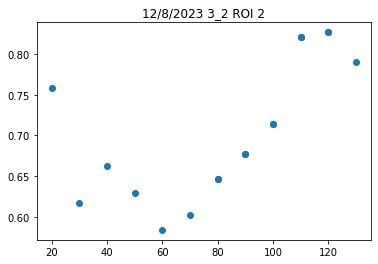

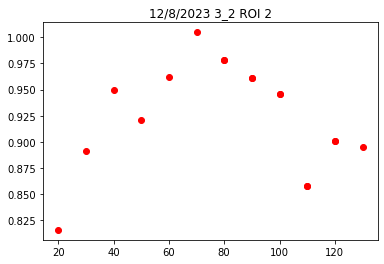

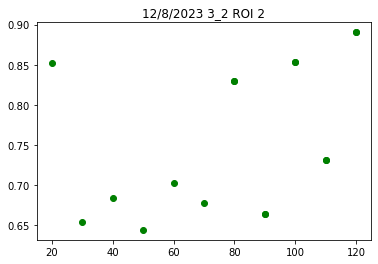

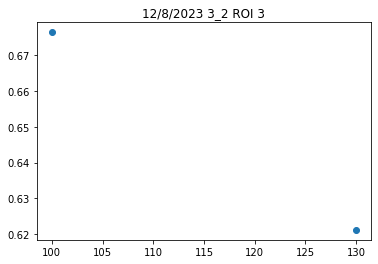

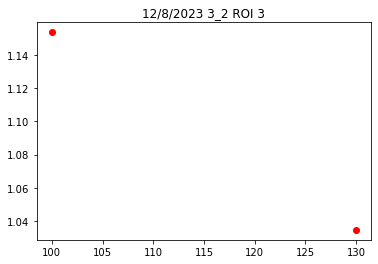

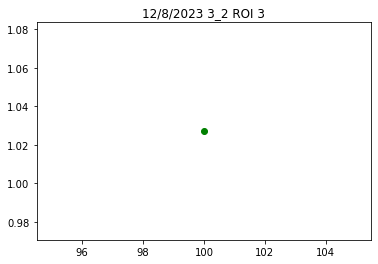

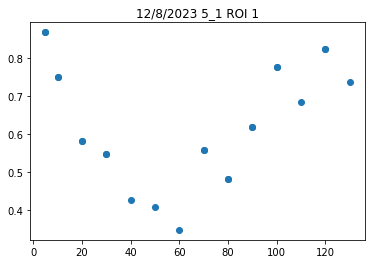

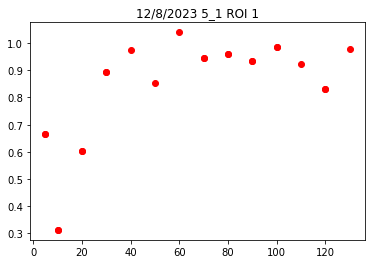

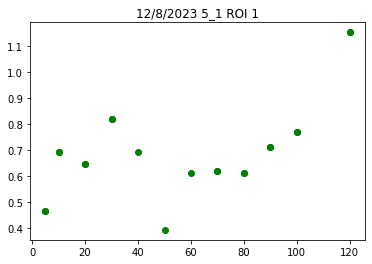

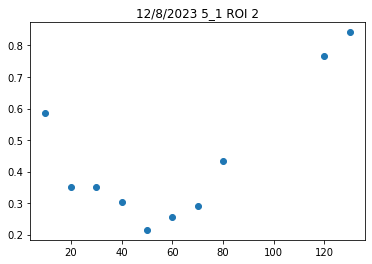

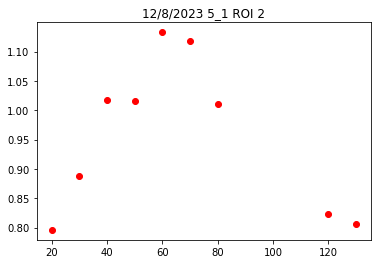

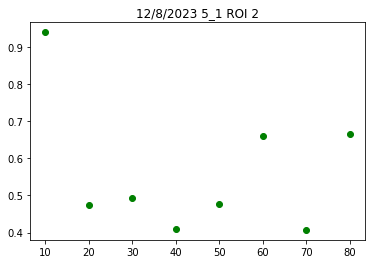

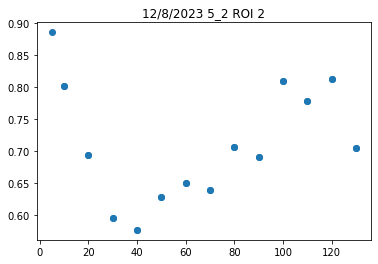

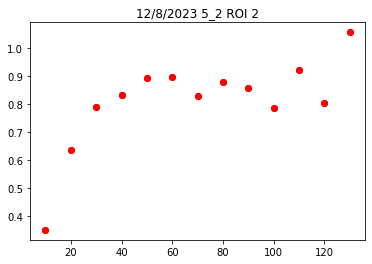

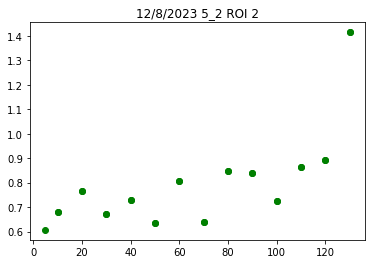

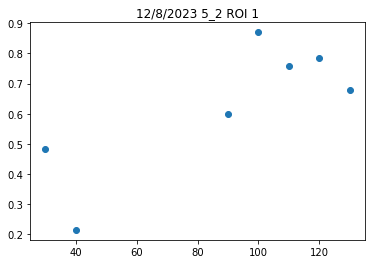

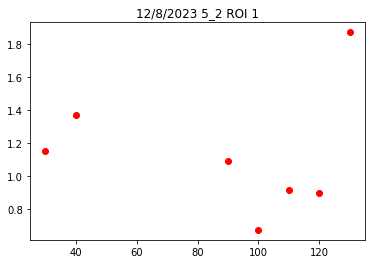

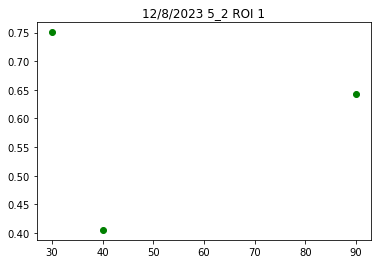

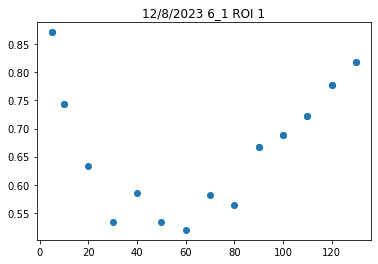

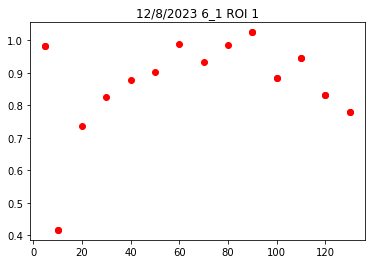

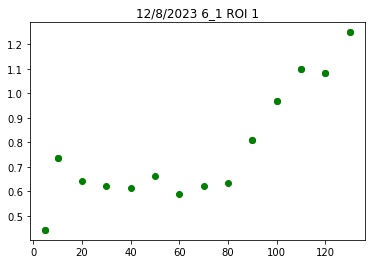

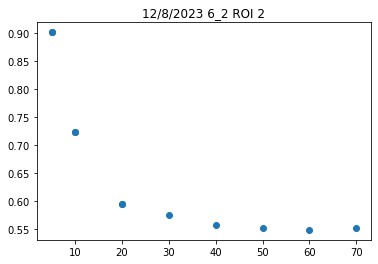

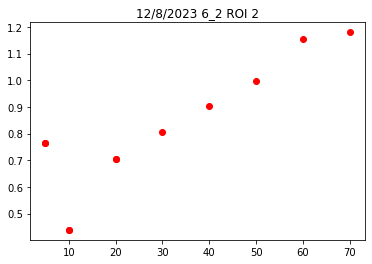

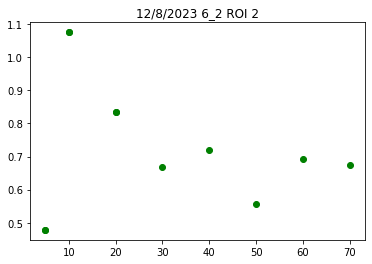

In [23]:
# for each date, slice/loc, and ROI, plot PPR vs IPI
for date in all_snr['Date'].unique():
    pfs_date = all_snr[all_snr["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR'])
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPL'], c='r')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPHW'], c='g')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()

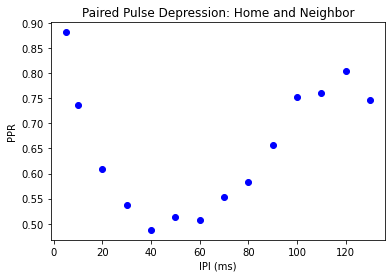

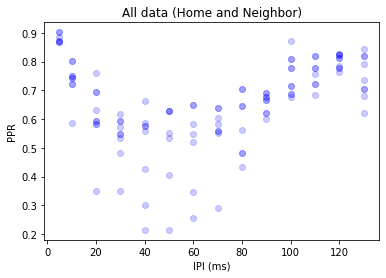

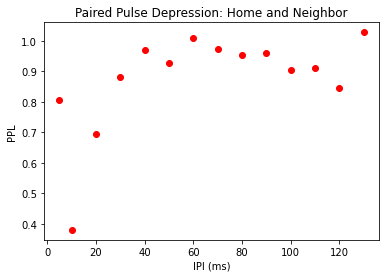

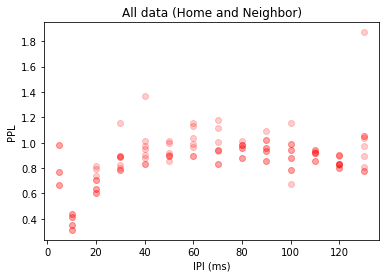

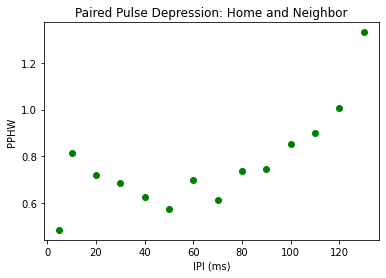

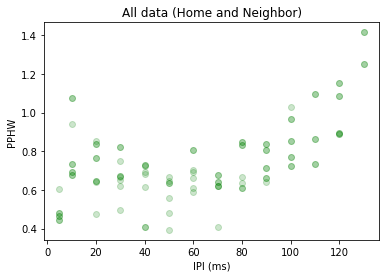

In [24]:
# average grouping by IPI
for pp_type, color in [['PPR', 'b'], ['PPL', 'r'], ['PPHW', 'g']]:
    group_by_ipi = all_snr[['IPI', pp_type]].groupby(by=['IPI']).mean()
    group_by_ipi_std = all_snr[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
    group_by_ipi.reset_index(inplace=True)
    
    

    # plot average PPR vs IPI
    plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
    plt.title("Paired Pulse Depression: Home and Neighbor")
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.show()
    plt.scatter(all_snr['IPI'], all_snr[pp_type], alpha=0.2, c=color)
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.title("All data (Home and Neighbor)")
    plt.show()

     PPR
IPI     
5      7
10     8
20     8
30     7
40     6
50     6
60     6
70     7
80     7
90     8
100    8
110    7
120    8
130    6
i= 0
5
p_val for IPI 10 : 3.499262852809432e-07
p_val for IPI 20 : 4.881072372111939e-06
p_val for IPI 30 : 1.2126658948097647e-09
p_val for IPI 40 : 5.9914524625066665e-05
p_val for IPI 50 : 0.00012144075252369524
p_val for IPI 60 : 0.0003581820324181082
p_val for IPI 70 : 3.5111662214529505e-08
p_val for IPI 80 : 0.00011236085528281331
p_val for IPI 90 : 5.770674321897844e-10
p_val for IPI 100 : 4.459591231102506e-05
p_val for IPI 110 : 0.000314412218509768
p_val for IPI 120 : 2.7655268436851053e-06
p_val for IPI 130 : 0.001173396804249497
[None, '***', '***', '***', '***', '***', '***', '***', '***', '***', '***', '***', '***', '**']


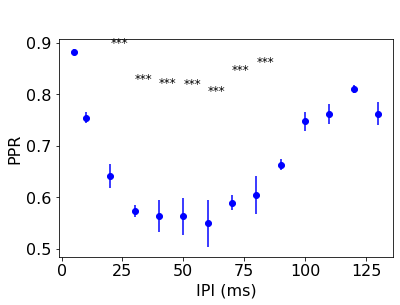

     PPR
IPI     
10     1
20     1
30     2
40     2
50     1
60     1
70     1
80     1
90     1
100    2
110    1
120    2
130    3
i= 1
110
p_val for IPI 10 : nan
p_val for IPI 20 : nan
p_val for IPI 30 : nan
p_val for IPI 40 : nan
p_val for IPI 50 : nan
p_val for IPI 60 : nan
p_val for IPI 70 : nan
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : nan
p_val for IPI 120 : nan
p_val for IPI 130 : nan
[None, None, None, None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0

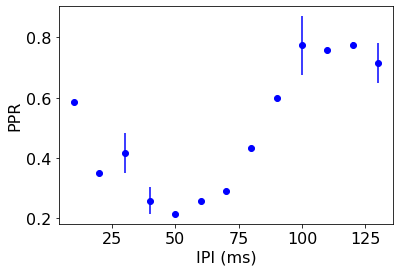

     PPL
IPI     
30     7
40     6
50     6
60     6
70     7
80     7
90     8
100    8
110    7
120    8
130    6
i= 0
30
p_val for IPI 40 : 0.9469428846460773
p_val for IPI 50 : 0.9871595008785773
p_val for IPI 60 : 0.994574736699532
p_val for IPI 70 : 0.9747372838754674
p_val for IPI 80 : 0.999113680029144
p_val for IPI 90 : 0.9979621567482149
p_val for IPI 100 : 0.9465627967324213
p_val for IPI 110 : 0.9933653615033824
p_val for IPI 120 : 0.5235816368615828
p_val for IPI 130 : 0.9096481799539311
[None, None, None, None, None, None, None, None, None, None, None]


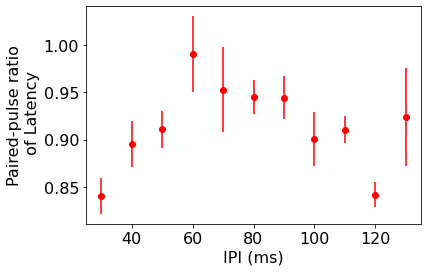

     PPL
IPI     
30     2
40     2
50     1
60     1
70     1
80     1
90     1
100    2
110    1
120    2
130    3
i= 1
30
p_val for IPI 40 : 0.7394508588303261
p_val for IPI 50 : nan
p_val for IPI 60 : nan
p_val for IPI 70 : nan
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : 0.37172262230825404
p_val for IPI 110 : nan
p_val for IPI 120 : 0.21422000464406213
p_val for IPI 130 : 0.7071500911328281
[None, None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0

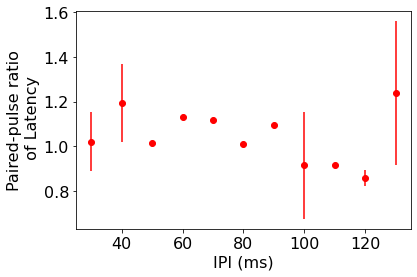

     PPHW
IPI      
30      7
40      6
50      6
60      6
70      7
80      7
90      8
100     8
110     6
120     8
130     4
i= 0
30
p_val for IPI 40 : 0.40391168808305955
p_val for IPI 50 : 0.025232281570557985
p_val for IPI 60 : 0.48239794226631594
p_val for IPI 70 : 0.046379594152108385
p_val for IPI 80 : 0.7637390166028609
p_val for IPI 90 : 0.8890783803288781
p_val for IPI 100 : 0.9906225097965882
p_val for IPI 110 : nan
p_val for IPI 120 : 0.9999472370148175
p_val for IPI 130 : nan
[None, None, '*', None, '*', None, None, None, None, None, None]


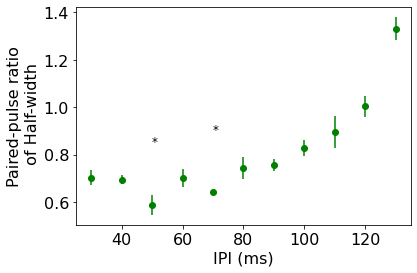

     PPHW
IPI      
30      2
40      2
50      1
60      1
70      1
80      1
90      1
100     1
110     0
120     0
130     0
i= 1
30
p_val for IPI 40 : 0.1718030292482862
p_val for IPI 50 : nan
p_val for IPI 60 : nan
p_val for IPI 70 : nan
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : nan
p_val for IPI 110 : nan
p_val for IPI 120 : nan
p_val for IPI 130 : nan
[None, None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0

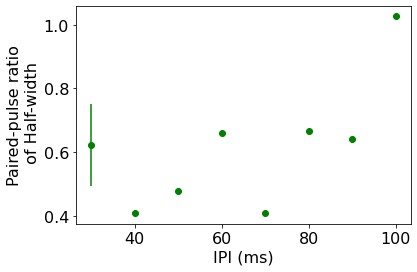

In [25]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = all_snr.query('`Home Barrel` == ROI')
neighbor_barrel_df = all_snr.query('`Home Barrel` != ROI')
titles = ['Home Barrel', 'Neighbor Barrel']

for pp_type, color in [['PPR', 'b'], ['PPL', 'r'], ['PPHW', 'g']]:
    i = 0
    for barrel_df in [home_barrel_df, neighbor_barrel_df]:
        
        if pp_type in ['PPL', 'PPHW']:
            barrel_df = barrel_df[barrel_df['IPI'] > 20]
        group_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).mean()
        group_by_ipi_std = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std) / np.sqrt(barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count())
        group_by_ipi.reset_index(inplace=True)

        count_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count()
        print(count_by_ipi)

        # significance tests against the first IPI
        first_ipi = np.min(group_by_ipi['IPI'])
        pvals = []
        print("i=", i)
        if pp_type == 'PPR' and titles[i] == 'Neighbor Barrel':
            first_ipi = 110
        print(first_ipi)
        
        first_ipi_data = barrel_df[barrel_df['IPI'] == first_ipi][pp_type]
        for ipi in group_by_ipi['IPI']:
            if ipi == first_ipi:
                pvals.append(1)
                continue
            ipi_data = barrel_df[barrel_df['IPI'] == ipi][pp_type]
            
            # Welch's (one-sided) t-test if ipi_data is less than first_ipi_data
            t_stat, p_val = ttest_ind(ipi_data, first_ipi_data, alternative='less', equal_var=False)
            print("p_val for IPI", ipi, ":", p_val)
            pvals.append(p_val)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        significance_levels = [get_sig_level(x) for x in pvals]
        print(significance_levels)
            

        plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
        plt.errorbar(group_by_ipi['IPI'], group_by_ipi[pp_type], 
                     group_by_ipi_std[pp_type], ls='none', c=color)
        y_label = pp_type
        if pp_type == 'PPL':
            y_label = "Paired-pulse ratio\n of Latency"
        if pp_type == 'PPHW':
            y_label = "Paired-pulse ratio\n of Half-width"
        # plt.title("Paired Pulse Depression in " + titles[i])
        
        # place significance levels on plot
        for j, txt in enumerate(significance_levels):
            plt.annotate(txt, (group_by_ipi['IPI'].iloc[j], min(0.95, group_by_ipi[pp_type].iloc[j] + 0.25)), fontsize=12)

        plt.xlabel("IPI (ms)")
        #plt.xticks([])
        plt.ylabel(y_label)
        plt.show()
        i += 1

In [26]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = all_snr.query('`Home Barrel` == ROI')
neighbor_barrel_df = all_snr.query('`Home Barrel` != ROI')
pvals = []
# significance tests: home versus neighbor
for ipi in group_by_ipi['IPI']:
    
    # one-sided t-test if ipi_data is less than first_ipi_data
    t_stat, p_val = ttest_ind(neighbor_barrel_df[neighbor_barrel_df['IPI'] == ipi]["PPR"],
                              home_barrel_df[home_barrel_df['IPI'] == ipi]["PPR"],  
                                alternative='less', 
                                equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

def get_sig_level(x):
    if x < 0.001:
        return '***'
    if x < 0.01:
        return '**'
    if x < 0.05:
        return '*'
significance_levels = [get_sig_level(x) for x in pvals]
print(significance_levels)

p_val for IPI 30 : 0.12107702954125943
p_val for IPI 40 : 0.012332255973676352
p_val for IPI 50 : nan
p_val for IPI 60 : nan
p_val for IPI 70 : nan
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : 0.5821841606856758
p_val for IPI 110 : nan
p_val for IPI 120 : 0.05075532076557369
p_val for IPI 130 : 0.276290636070835
[None, '*', None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0

58
34


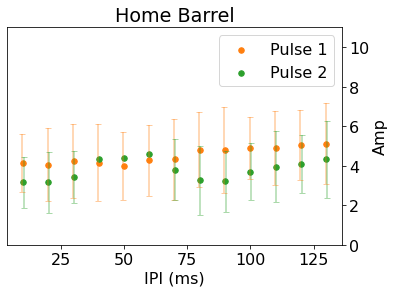

(13,) (13,) (13,) (13,)


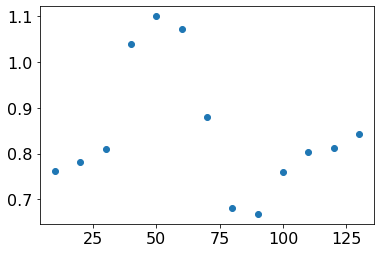

58
34


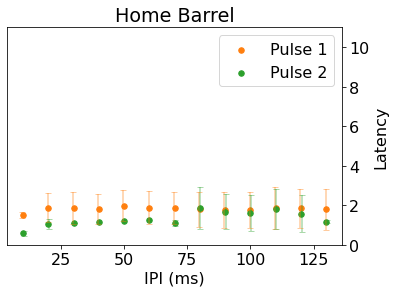

(13,) (13,) (13,) (13,)


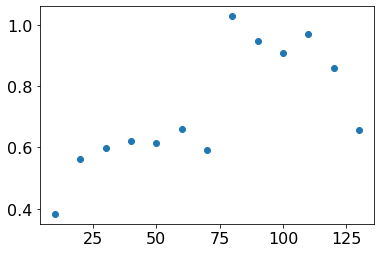

58
34


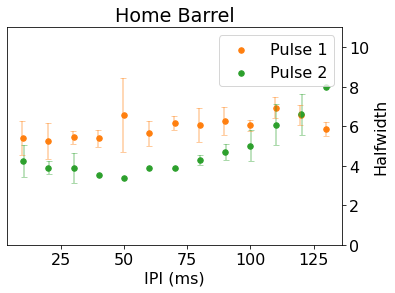

(13,) (13,) (13,) (13,)


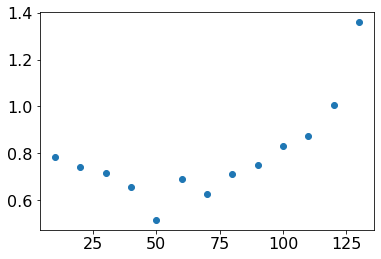

17
2


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


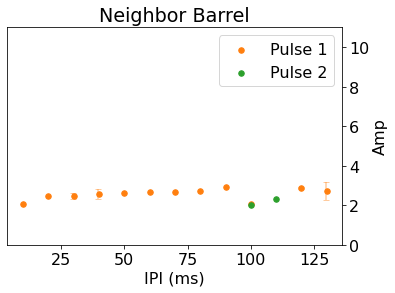

(12,) (12,) (2,) (12,)


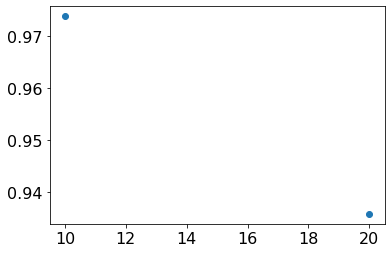

17
2


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


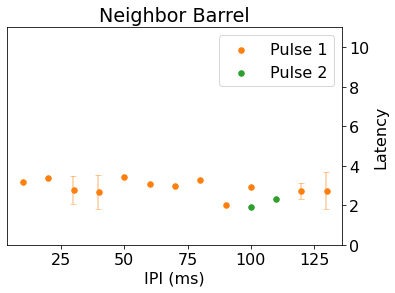

(12,) (12,) (2,) (12,)


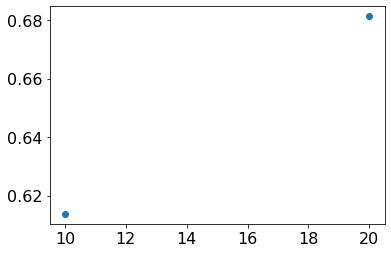

17
2


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


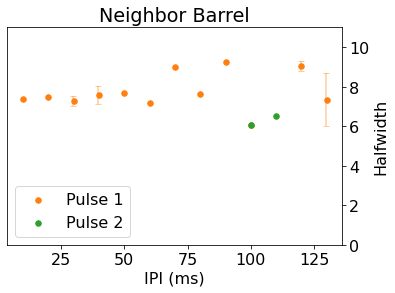

(12,) (12,) (2,) (12,)


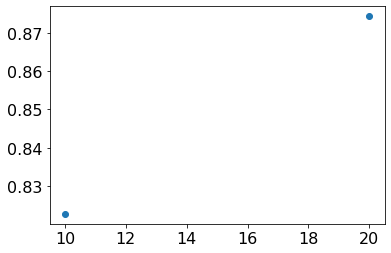

In [27]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.5
should_group_by_ipi = True
if should_group_by_ipi:
    alpha = 1
ppr_snr = all_snr.query('PPR > 0')
ppr_snr = ppr_snr.query('PPR < 2')
pulse1_df = ppr_snr.query('Pulse == 1')
pulse2_df = ppr_snr.query('Pulse == 2')
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']

for barrel in ['Home Barrel', 'Neighbor Barrel']:
    for met_type, color in [['Amp', 'b'], ['Latency', 'r'], ['Halfwidth', 'g']]:
        i = 0
        end1, end2 = None, None
        for pulse_df in [pulse1_df, pulse2_df]:
            total_n = len(pulse_df['IPI'])
            if barrel == 'Home Barrel':
                pulse_df = pulse_df.query('`Home Barrel` == ROI')
            else:
                pulse_df = pulse_df.query('`Home Barrel` != ROI')
            pulse_df = pulse_df[pulse_df['IPI'] > 5]
            subset_n = len(pulse_df['IPI'])
            print(len(pulse_df['IPI']))
            if should_group_by_ipi:
                pulse_df_std = pulse_df[['IPI', met_type]].groupby(by=['IPI']).agg(np.std)
                pulse_df = pulse_df[['IPI', met_type]].groupby(by=['IPI']).mean()
                pulse_df.reset_index(inplace=True)
                plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df[met_type], 
                            pulse_df_std[met_type], ls='none', c=pulse_colors[i], capsize=3, alpha=0.4)
            if end1 is None:
                end1 = pulse_df
            else:
                end2 = pulse_df
            plt.scatter(pulse_df['IPI'], pulse_df[met_type], alpha=alpha,
                        s=30,
                        color=pulse_colors[i],
                         label=titles[i] )
            i += 1
        plt.title(barrel)
        plt.xlabel("IPI (ms)")
        plt.ylabel(met_type)
        plt.ylim(0, 11)
        plt.legend()
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        
        plt.show()
        ppr = end2[met_type] / end1[met_type]
        print(ppr.shape, end1[met_type].shape, end2['IPI'].shape, end1['IPI'].shape)
        plt.scatter(end1['IPI'], ppr)
        plt.show()


     IPI      Amp
0     20  1.04767
1     30  1.15874
2     40  1.12238
3     50  1.25799
4     60  1.32523
..   ...      ...
206  100  1.50981
207  110  1.34750
208  120  1.26173
209  130  1.18438
210  140  1.20338

[198 rows x 2 columns]
     IPI       Amp
0     20  0.747929
1     30  0.530139
2     40  0.553891
3     50  0.463109
4     60  0.404570
..   ...       ...
206  100  0.958694
207  110  0.918727
208  120  1.052120
209  130  1.101890
210  140  1.042970

[198 rows x 2 columns]


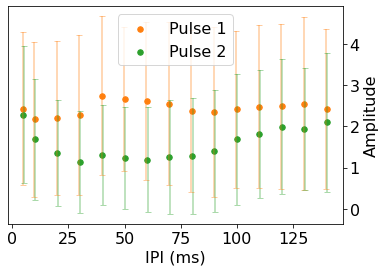

In [28]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.2
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']
should_group_by_ipi = True
i = 0
if should_group_by_ipi:
    alpha = 1
for amp in [amps1, amps2]:

    if should_group_by_ipi:
        pulse_df = pd.DataFrame({'IPI': ipis, 'Amp': amp})
        pulse_df = pulse_df[pulse_df['IPI'] <150]
        print(pulse_df)
        pulse_df_std = pulse_df[['IPI', 'Amp']].groupby(by=['IPI']).agg(np.std)
        pulse_df = pulse_df[['IPI', 'Amp']].groupby(by=['IPI']).mean()
        pulse_df.reset_index(inplace=True)
        plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df['Amp'], 
                    pulse_df_std['Amp'], ls='none', c=pulse_colors[i], 
                    capsize=3, alpha=0.4)

    plt.scatter(pulse_df['IPI'], pulse_df['Amp'], alpha=alpha,
                s=30,
                color=pulse_colors[i],
                    label=titles[i] )
    i += 1
plt.xlabel("IPI (ms)")
plt.ylabel('Amplitude')
plt.legend()
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.show()

In [29]:
print(np.std(amps1), np.std(amps2))

1.870824556947021 1.4458107688717046


In [30]:
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "ampArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

overwrite_amp_arrays = False
select_amp_bkg = False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not select_amp_bkg and enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]

            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:

                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                # check if all amp arrays are already saved for this recording/IPI
                all_saved = True
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename):
                        print("Missing", amp_array_filename)
                        all_saved = False
                        break
                if overwrite_amp_arrays:
                    all_saved = False

                if enable_photoZ_interact and not all_saved:
                    aPhz.open_zda_file(zda_file)

                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename) or overwrite_amp_arrays:
                        if enable_photoZ_interact and not all_saved:
                            measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                            aPhz.set_measure_window(measure_window_start, None)

                            # change polynomial skip window too to match measure window
                            aPhz.set_polynomial_skip_window(measure_window_start)

                        # take Amplitude array from PhotoZ
                        if enable_photoZ_interact and not all_saved:
                            aPhz.save_background(filename=amp_array_filename)
                    else:
                        if not all_saved:
                            time.sleep(5)

                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_pulse not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['amp_array'] = amp_array_filename
                    
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
                        

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06.z